# YZV 303E Term Project: Retinal Layer Segmentation of OCT Images

* Öykü Eren, 150200326
* Bora Boyacıoğlu, 150200310

## 1. Data Processing and Saving

This part is specific for loading the OCTA 500 data, applying transformations if necessary, and saving it into a NumPy archive file to use it later.

Import necessary libraries.

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split

from scipy.io import loadmat
import cv2

import openpyxl

In [3]:
# For better visualisations
%config InlineBackend.figure_format = 'svg'
%matplotlib inline

Import the data from Google Drive.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Define the global variables.

In [4]:
# Image extension
IMG_EXT = '.bmp'

# Define the sizes for preprocessing
IMG_SIZE = 640
CROP_SIZE = 400
RESIZE = 512

Get the data locations.

In [5]:
data_location = 'drive/MyDrive/OCTA500'

In [6]:
oct_6mm_loc = data_location + '/OCTA_6mm/OCT'
oct_3mm_loc = data_location + '/OCTA_3mm/OCT'

labels_loc = data_location + '/Label/GT_Layers'

text_6mm_loc = data_location + '/OCTA_6mm/Text labels.xlsx'
text_3mm_loc = data_location + '/OCTA_3mm/Text labels.xlsx'

In [7]:
oct_6mm_loc = data_location + '/OCTA_6mm/OCT'
oct_3mm_loc = data_location + '/OCTA_3mm/OCT'

labels_loc = data_location + '/Label/GT_Layers'

Import utils from Drive.

### Loading the Images

Define a stack loader function. This will read and combine all the slices of one sample.

In [8]:
def preprocess(img):
    """ Preprocessing the images in the loop
    """

    # Get the image sizes
    s0, s1 = img.shape[:2]  # Height, Width

    # Crop the image
    y0 = (s0 - CROP_SIZE) // 2
    y1 = CROP_SIZE + y0
    img = img[y0:y1, :, :]

    # Add padding to the 3mm images
    if s1 < CROP_SIZE:
        w = max((CROP_SIZE - s1) // 2, 0)
        img = cv2.copyMakeBorder(img, 0, 0, w, w, cv2.BORDER_CONSTANT, value=(0, 0, 0))

    # Resize the image
    img = cv2.resize(img, (RESIZE, RESIZE))

    return img

In [9]:
def load_3d_img(path, read_slices):
    """Load 2D image slices from a specified path, normalize the pixel values, and stack them along the last axis to form a 3D image.
    """

    slices = []
    current_slices = []

    # Read the slices
    for i in read_slices:
        sliced = None
        j = i

        """
        Some of the files are broken.
        This means, we need to try to find the next non-empty slice.
        """
        while True:
            try:
                file_path = path + '/' + str(j) + IMG_EXT
                sliced = cv2.imread(file_path)
                sliced = sliced.astype('float32') / 255.0
                current_slices.append(j)
                break
            except AttributeError:
                j -= 1

        # Preprocess the slice
        sliced = preprocess(sliced)
        slices.append(sliced)

    return slices, current_slices

Run the stack loader for each sample. Using the results, build arrays for 3mm and 6mm OCT images, as well as the layers.

In [10]:
def label_preprocess(label, read_slices):
    """ Preprocessing the labels in the loop
    """

    # Crop the label
    y0 = (IMG_SIZE - CROP_SIZE) // 2
    y1 = CROP_SIZE + y0

    label = label - y0
    label = np.clip(label, 0, y1 - y0)

    slice_count = len(read_slices)
    width = label.shape[2]

    # Convert the label to mask
    mask = np.zeros((slice_count, 6, y1 - y0, width), dtype=np.uint8)

    for i, depth in enumerate(read_slices):
        sliced = label[:, depth, :]
        for j, layer in enumerate(sliced):
            for x, y in enumerate(layer):
                if 0 <= y < y1 - y0:
                    mask[i, j, y, x] = 1

    # Resize the mask
    mask_ = np.zeros((slice_count, 6, RESIZE, RESIZE), dtype=np.uint8)

    for i in range(6):
        for sliced in range(slice_count):
            layer = mask[sliced, i]

            # Add padding to the 3mm labels
            if width < CROP_SIZE:
                w = max((CROP_SIZE - width) // 2, 0)
                layer = cv2.copyMakeBorder(mask[sliced, i], 0, 0, w, w, cv2.BORDER_CONSTANT, value=(0, 0, 0))

            mask_[sliced, i] = (cv2.resize(layer, (RESIZE, RESIZE), interpolation=cv2.INTER_NEAREST))

    return mask_

In [11]:
# For anomaly detection, we don't need the images. So, don't waste time processing them.
do_img = true

# For test purposes, only work with a couple of samples
test = True
s6, s3 = 50, 50
test_sample = list(range(10001, 10001 + s6)) + list(range(10301, 10301 + s3))

# Number of slices to work with
slice_count = 20
read_slices_6mm = [int((400 / slice_count) * (i + 1) - 1) for i in range(slice_count)]
read_slices_3mm = [int((304 / slice_count) * (i + 1) - 1) for i in range(slice_count)]

# Define the arrays
oct_6mm, oct_3mm = [], []
label_6mm, label_3mm = [], []

processed = 0

print(f'Processing starts with{f" " + str(s6 + s3) + " samples" if test else "out"} testing' +
      f', and {str(slice_count)} slices.')

# Iterate over samples
for i in range(10001, 10501):
    # For test purposes
    if test and i not in test_sample:
        continue
    processed += 1

    if i < 10301:
        # The case for 6mm
        print(f'Processing 6mm, Sample: {i}, Slices: {slice_count}...')

        read_slices = read_slices_6mm

        if do_img:
            # Load the image
            path = oct_6mm_loc + '/' + str(i)
            img, read_slices = load_3d_img(path, read_slices_6mm)
            oct_6mm.append(img)

        # Add the label
        path_label = labels_loc + '/' + str(i) + '.mat'
        mat = loadmat(path_label)['Layer']
        label = label_preprocess(mat, read_slices)
        label_6mm.append(label)
    else:
        # The case for 3mm
        print(f'Processing 3mm, Sample: {i}, Slices: {slice_count}...')

        read_slices = read_slices_3mm

        if do_img:
            # Load the image
            path = oct_3mm_loc + '/' + str(i)
            img, read_slices = load_3d_img(path, read_slices_3mm)
            oct_3mm.append(img)

        # Add the label
        path_label = labels_loc + '/' + str(i) + '.mat'
        mat = loadmat(path_label)['Layer']
        label = label_preprocess(mat, read_slices)
        label_3mm.append(label)

print('-- PROCESSING DONE --')
print(f'From {processed} samples and {slice_count} slices of each, a total of {processed * slice_count} slices processed.')

Processing starts with 300 samples testing, and 50 slices.
Processing 6mm, Sample: 10001, Slices: 50...
Processing 6mm, Sample: 10002, Slices: 50...
Processing 6mm, Sample: 10003, Slices: 50...
Processing 6mm, Sample: 10004, Slices: 50...
Processing 6mm, Sample: 10005, Slices: 50...
Processing 6mm, Sample: 10006, Slices: 50...
Processing 6mm, Sample: 10007, Slices: 50...
Processing 6mm, Sample: 10008, Slices: 50...
Processing 6mm, Sample: 10009, Slices: 50...
Processing 6mm, Sample: 10010, Slices: 50...
Processing 6mm, Sample: 10011, Slices: 50...
Processing 6mm, Sample: 10012, Slices: 50...
Processing 6mm, Sample: 10013, Slices: 50...
Processing 6mm, Sample: 10014, Slices: 50...
Processing 6mm, Sample: 10015, Slices: 50...
Processing 6mm, Sample: 10016, Slices: 50...
Processing 6mm, Sample: 10017, Slices: 50...
Processing 6mm, Sample: 10018, Slices: 50...
Processing 6mm, Sample: 10019, Slices: 50...
Processing 6mm, Sample: 10020, Slices: 50...
Processing 6mm, Sample: 10021, Slices: 50

In [12]:
wb_6mm = openpyxl.load_workbook(text_6mm_loc)
wb_3mm = openpyxl.load_workbook(text_3mm_loc)

sheet_6mm = wb_6mm.active
sheet_3mm = wb_3mm.active

text_6mm = np.array([0 if sheet_6mm[f'E{i + 1}'].value == 'NORMAL' else 1 for i in range(s6)])
text_3mm = np.array([0 if sheet_3mm[f'E{i + 1}'].value == 'NORMAL' else 1 for i in range(s3)])

In [ ]:
concatenate = False

if concatenate:
    oct_3mm = np.concatenate(oct_3mm, axis=0)
    oct_6mm = np.concatenate(oct_6mm, axis=0)

    label_3mm = np.concatenate(label_3mm, axis=0)
    label_6mm = np.concatenate(label_6mm, axis=0)

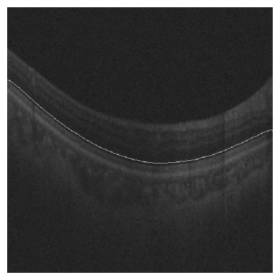

In [ ]:
sample = 41 # [0, 4]
sliced = 16  # [0, 19]
layer = 3   # [0, 5]

n = sample * 20 + sliced

plt.imshow(oct_6mm[n])
plt.imshow(label_6mm[n][layer], cmap='gray', alpha=0.75)

# Show the plot
plt.show()

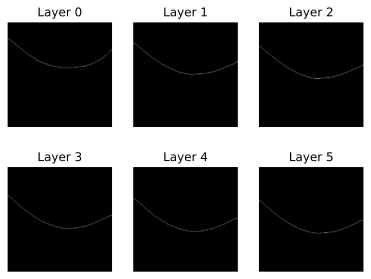

In [ ]:
sample = 41
sliced = 16

n = sample * 20 + sliced

fig, axs = plt.subplots(2, 3)

for i in range(6):
    # Hide axes
    axs[i // 3, i % 3].axis('off')

    # Set title for each plot: Their layer id
    axs[i // 3, i % 3].set_title(f'Layer {i}')

    # Plot the image
    axs[i // 3, i % 3].imshow(label_6mm[n][i], cmap='gray', alpha=1)

plt.savefig('layers.svg')
plt.show()


In [13]:
combined_1, combined_2 = None, None

if do_img:
    combined_1 = np.concatenate((oct_6mm, oct_3mm), axis=0)
    print("Shape of all image data:", combined_1.shape)

    combined_2 = np.concatenate((label_6mm, label_3mm), axis=0)
    print("Shape of all masks data:", combined_2.shape)
else:
    combined_1 = np.concatenate((label_6mm, label_3mm), axis=0)
    print("Shape of all masks data:", combined_1.shape)

    combined_2 = np.concatenate((text_6mm, text_3mm), axis=0)
    print("Shape of all text data:", combined_2.shape)

Shape of all masks data: (300, 50, 6, 512, 512)
Shape of all text data: (300,)


In [14]:
X_train, X_test, y_train, y_test = train_test_split(combined_1, combined_2,
                                                    random_state=1773,
                                                    test_size=0.25,
                                                    shuffle=True)

In [16]:
save_location = data_location + '/Project/data/'

# Check for test purposes
if test:
    save_location += 'test/'

if do_img:
    np.savez_compressed(f'{save_location}train.npz', img=X_train, mask=y_train)
    np.savez_compressed(f'{save_location}test.npz', img=X_test, mask=y_test)
else:
    np.savez_compressed(f'{save_location}mt_train.npz', mask=X_train, text=y_train)
    np.savez_compressed(f'{save_location}mt_test.npz', mask=X_test, text=y_test)

print("Saving Done.")

Saving Done.
